<h1 style="font-family:verdana;"> <center>📚  Notebook: Transfer Learning on Animal Species Dataset 🐶🕸️🐴🐘🐄</center> </h1>
<p><center style="color:#f44336; font-family:cursive;">Let's Start</center></p>

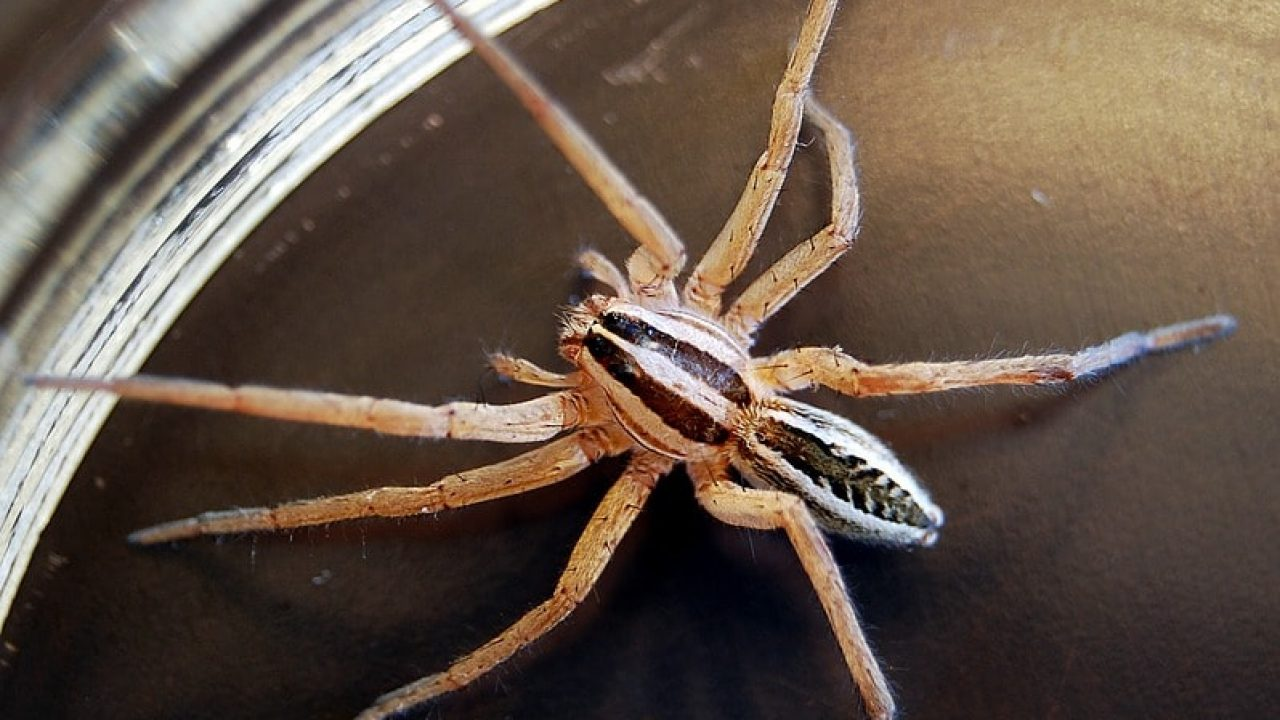

# Table Of Content
* [Import Libraries](#Import-libraries)
* [Load Dataset](#Load-dataset)
* [Data Visualization](#Visualization)

- *VGG16*
 * [Model Load](#VGG16-Model-load)
 * [Train Model](#VGG16-Model-train)
 * [Fine Tuning](#fine-tuning)
- *save Model*
 * [Load Saved Model](#saved)

# Import Libraries 📚 <a class="anchor"  id="Import-libraries">

#### all Here

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import cv2
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from tensorflow.keras.models import load_model

plt.rcParams['font.size'] = 10

### Check GPU

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Load Dataset <a class="anchor"  id="Load-dataset">

In [7]:
raw_img = '/kaggle/input/animals10/raw-img'

translate = {
    "cane": "dog",
    "cavallo": "horse",
    "elefante": "elephant",
    "farfalla": "butterfly",
    "gallina": "chicken",
    "gatto": "cat",
    "mucca": "cow",
    "pecora": "sheep",
     "ragno":"spider",
    "scoiattolo": "squirrel",
   
}

# Get class names from directory names
class_names = sorted(os.listdir(raw_img))
print("Class names:")
for i in class_names:
    print( i,'/',translate[i])

Class names:
cane / dog
cavallo / horse
elefante / elephant
farfalla / butterfly
gallina / chicken
gatto / cat
mucca / cow
pecora / sheep
ragno / spider
scoiattolo / squirrel


# Data Visualization  <a class="anchor"  id="Visualization">

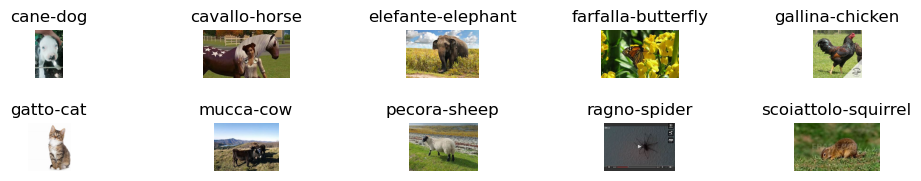

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 2))
fig.tight_layout()

# Load and display a random image from each class
for i, cls in enumerate(class_names):
    ax = axs[i // 5][i % 5]
    img_path = os.path.join(raw_img, cls, os.listdir(os.path.join(raw_img, cls))[np.random.randint(0, len(os.listdir(os.path.join(raw_img, cls))))])
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{cls}-{translate[cls]}')
    
plt.show()

### Loading Dataset with Data augmentation

In [39]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Specify the validation split ratio here
)


In [40]:


# Create generators for training and validation data
train_generator = train_datagen.flow_from_directory(
    raw_img,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    raw_img,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


# Transfer Learning using VGG16 <a class="anchor"  id="VGG16-Model-load">

In [64]:

vgg_mode=tf.keras.applications.vgg16.VGG16(include_top=False,
                                             weights='imagenet',
                                             input_shape=(224, 224,3))

for layer in vgg_mode.layers:
    layer.trainable=False

### require callbacks

In [67]:
model_name = "vgg_best.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)
tensorboard = TensorBoard(log_dir='logs', histogram_freq=1, write_graph=True, write_images=True)

 

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [68]:
x = vgg_mode.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(10, activation='softmax')(x)

    # Define the new model
model = tf.keras.models.Model(inputs=vgg_mode.input, outputs=predictions)

In [69]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)


In [70]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

# VGG16 Train Model <a class="anchor"  id="VGG16-Model-train">

In [71]:
history = model.fit(train_generator, epochs=2, validation_data=val_generator,verbose = 1, callbacks=[checkpoint, earlystopping, tensorboard])


Epoch 1/2
655/655 [==============================] - ETA: 0s - loss: 1.0851 - accuracy: 0.6357 - top_k_accuracy: 0.7839
Epoch 1: val_loss improved from inf to 0.73961, saving model to vgg_best.h5
655/655 [==============================] - 432s 659ms/step - loss: 1.0851 - accuracy: 0.6357 - top_k_accuracy: 0.7839 - val_loss: 0.7396 - val_accuracy: 0.7559 - val_top_k_accuracy: 0.8788
Epoch 2/2
655/655 [==============================] - ETA: 0s - loss: 0.7574 - accuracy: 0.7457 - top_k_accuracy: 0.8746
Epoch 2: val_loss improved from 0.73961 to 0.63870, saving model to vgg_best.h5
655/655 [==============================] - 397s 605ms/step - loss: 0.7574 - accuracy: 0.7457 - top_k_accuracy: 0.8746 - val_loss: 0.6387 - val_accuracy: 0.7888 - val_top_k_accuracy: 0.8974


## Plotting the Loss Curve

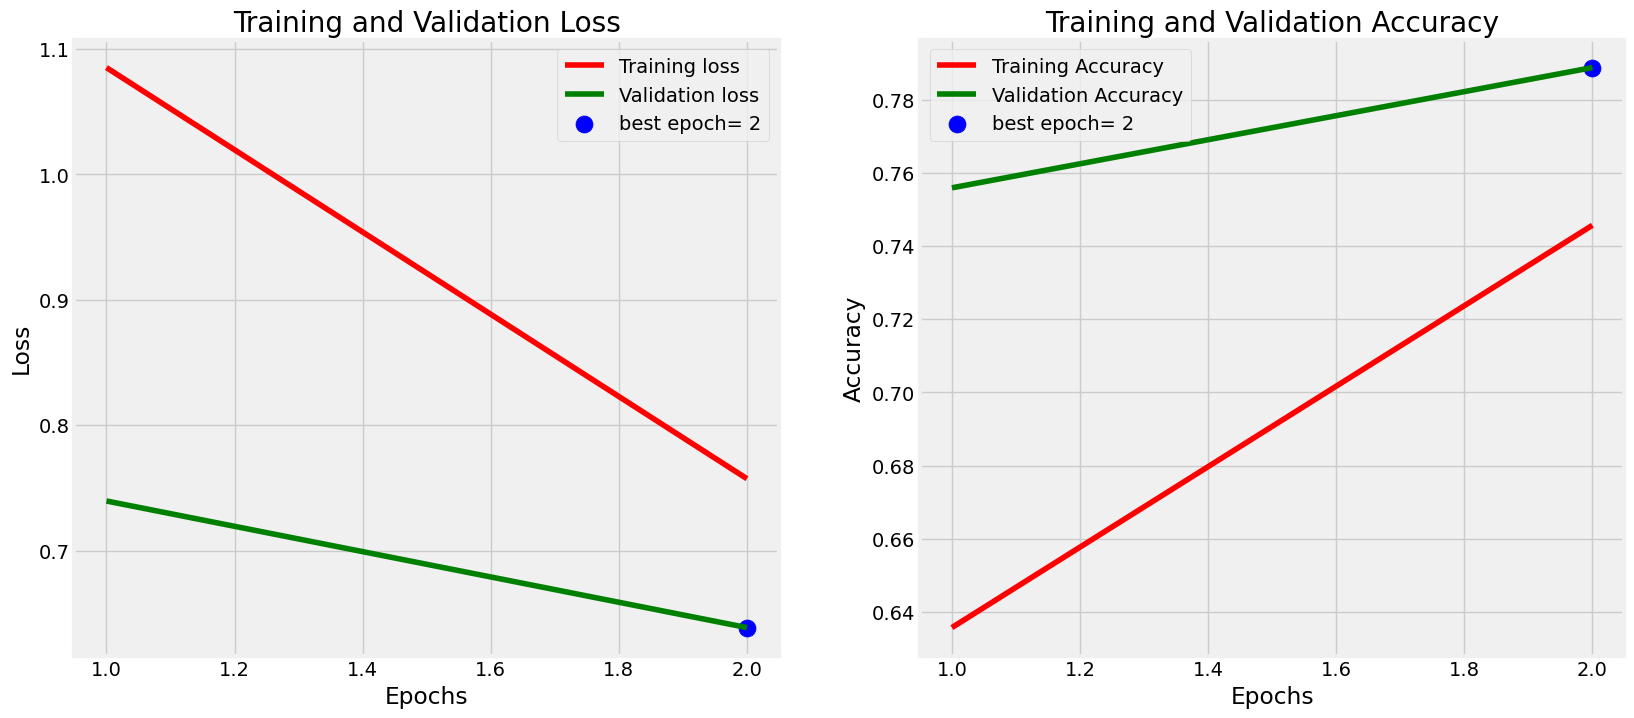

In [72]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

### Evalution

In [82]:
img_path = "/kaggle/input/animals10/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg"

test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (224 ,224))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

preds = model.predict(img_array)

print(class_names[np.argmax(preds[0])],'-',translate[class_names[np.argmax(preds[0])]])

(1, 224, 224, 3)
1/1 [==============================] - 0s 34ms/step
cane - dog


In [80]:
model.evaluate(validation_dataset)

164/164 [==============================] - 66s 402ms/step - loss: 0.6428 - accuracy: 0.7846 - top_k_accuracy: 0.8935


[0.6428403258323669, 0.7845947742462158, 0.8935397267341614]

**lets train for some more epochs**

### train -2

In [83]:
history = model.fit(train_generator, epochs=25, validation_data=val_generator,verbose = 1, callbacks=[checkpoint, earlystopping, tensorboard])


Epoch 1/25
655/655 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7704 - top_k_accuracy: 0.8886
Epoch 1: val_loss improved from 0.63870 to 0.60560, saving model to vgg_best.h5
655/655 [==============================] - 395s 603ms/step - loss: 0.6810 - accuracy: 0.7704 - top_k_accuracy: 0.8886 - val_loss: 0.6056 - val_accuracy: 0.7980 - val_top_k_accuracy: 0.9010
Epoch 2/25
655/655 [==============================] - ETA: 0s - loss: 0.6449 - accuracy: 0.7815 - top_k_accuracy: 0.8972
Epoch 2: val_loss improved from 0.60560 to 0.57532, saving model to vgg_best.h5
655/655 [==============================] - 396s 605ms/step - loss: 0.6449 - accuracy: 0.7815 - top_k_accuracy: 0.8972 - val_loss: 0.5753 - val_accuracy: 0.8096 - val_top_k_accuracy: 0.9088
Epoch 3/25
655/655 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.7930 - top_k_accuracy: 0.9045
Epoch 3: val_loss improved from 0.57532 to 0.56559, saving model to vgg_best.h5
655/655 [==========

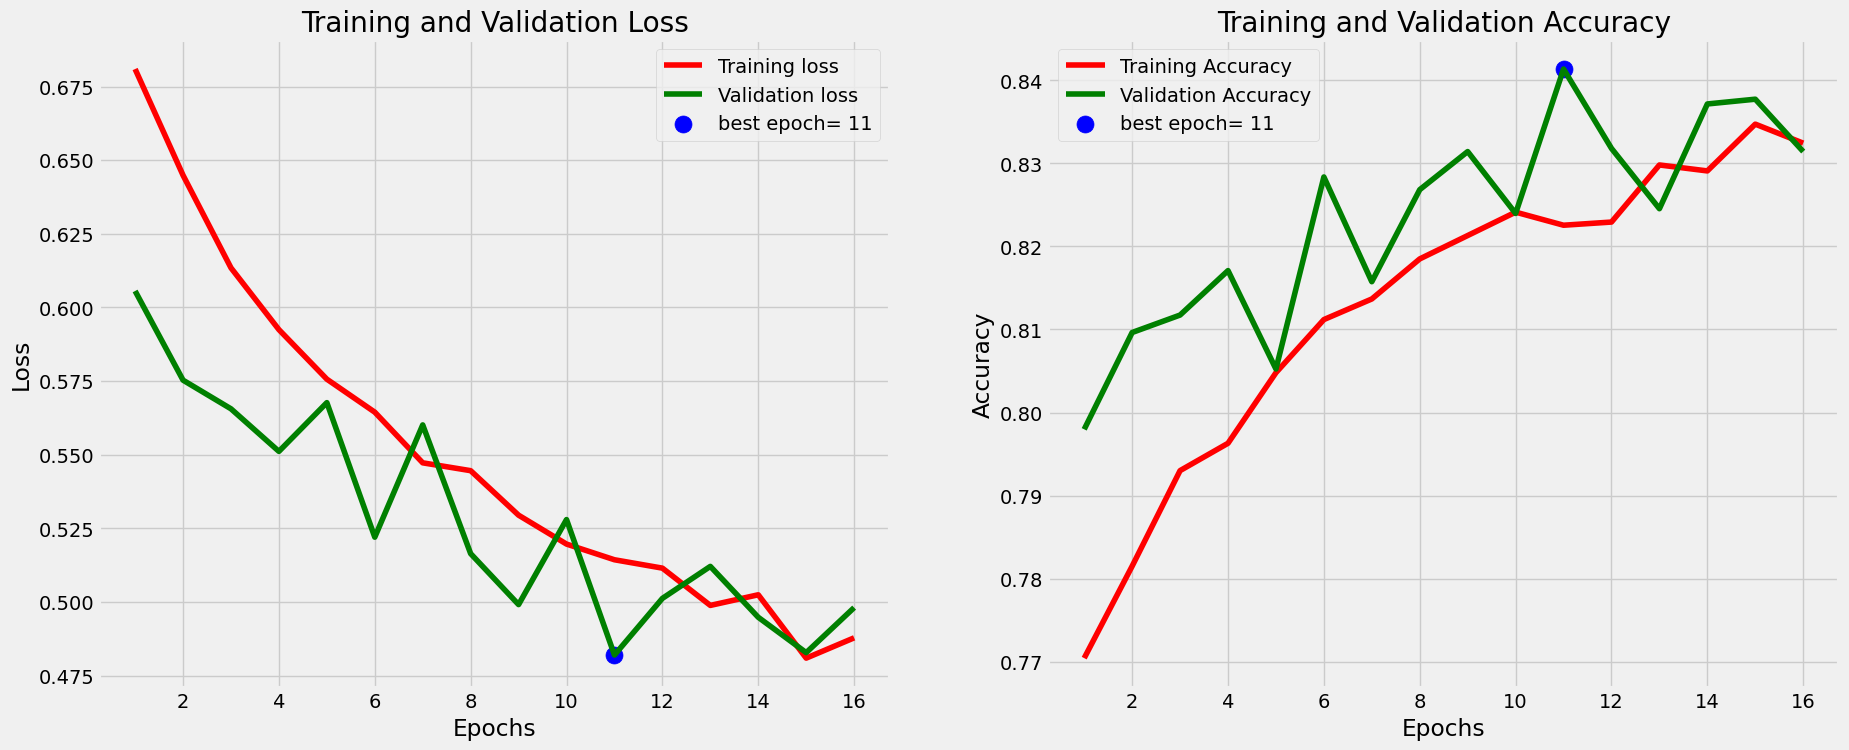

In [84]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [86]:
results = model.evaluate(val_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.48336
Test Accuracy: 83.85%


#### F1 Score / Recall / Precision


In [92]:
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

F1 Score: 0.09880883403810288
              precision    recall  f1-score   support

        cane       0.20      0.22      0.21       972
     cavallo       0.10      0.10      0.10       524
    elefante       0.05      0.04      0.05       289
    farfalla       0.07      0.06      0.06       422
     gallina       0.13      0.11      0.12       619
       gatto       0.06      0.05      0.06       333
       mucca       0.07      0.07      0.07       373
      pecora       0.05      0.05      0.05       364
       ragno       0.19      0.20      0.20       964
  scoiattolo       0.07      0.08      0.08       372

    accuracy                           0.13      5232
   macro avg       0.10      0.10      0.10      5232
weighted avg       0.12      0.13      0.12      5232



In [93]:
img_path = "/kaggle/input/animals10/raw-img/ragno/OIP--3TXG7fjM50XlBjTpcsfMgHaHa.jpeg"

test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (224 ,224))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

preds = model.predict(img_array)

print(class_names[np.argmax(preds[0])],'-',translate[class_names[np.argmax(preds[0])]])

(1, 224, 224, 3)
1/1 [==============================] - 0s 34ms/step
ragno - spider


## Fine Tuning <a class="anchor"  id="fine-tuning">

In [94]:
for layer in vgg_mode.layers:
        layer.trainable = True

In [98]:
for layer in vgg_mode.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False


In [100]:
for l in vgg_mode.layers[:10]:
    print(l.name, l.trainable)

input_2 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True


In [103]:
model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=metrics
)

In [104]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [105]:
history = model.fit(train_generator, epochs=25, validation_data=val_generator,verbose = 1, callbacks=[checkpoint, earlystopping, tensorboard])

Epoch 1/25
655/655 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8902 - top_k_accuracy: 0.9558
Epoch 1: val_loss improved from 0.48198 to 0.21668, saving model to vgg_best.h5
655/655 [==============================] - 392s 599ms/step - loss: 0.3001 - accuracy: 0.8902 - top_k_accuracy: 0.9558 - val_loss: 0.2167 - val_accuracy: 0.9249 - val_top_k_accuracy: 0.9746
Epoch 2/25
655/655 [==============================] - ETA: 0s - loss: 0.1877 - accuracy: 0.9388 - top_k_accuracy: 0.9793
Epoch 2: val_loss improved from 0.21668 to 0.18590, saving model to vgg_best.h5
655/655 [==============================] - 396s 604ms/step - loss: 0.1877 - accuracy: 0.9388 - top_k_accuracy: 0.9793 - val_loss: 0.1859 - val_accuracy: 0.9417 - val_top_k_accuracy: 0.9801
Epoch 3/25
655/655 [==============================] - ETA: 0s - loss: 0.1414 - accuracy: 0.9549 - top_k_accuracy: 0.9859
Epoch 3: val_loss improved from 0.18590 to 0.16873, saving model to vgg_best.h5
655/655 [==========

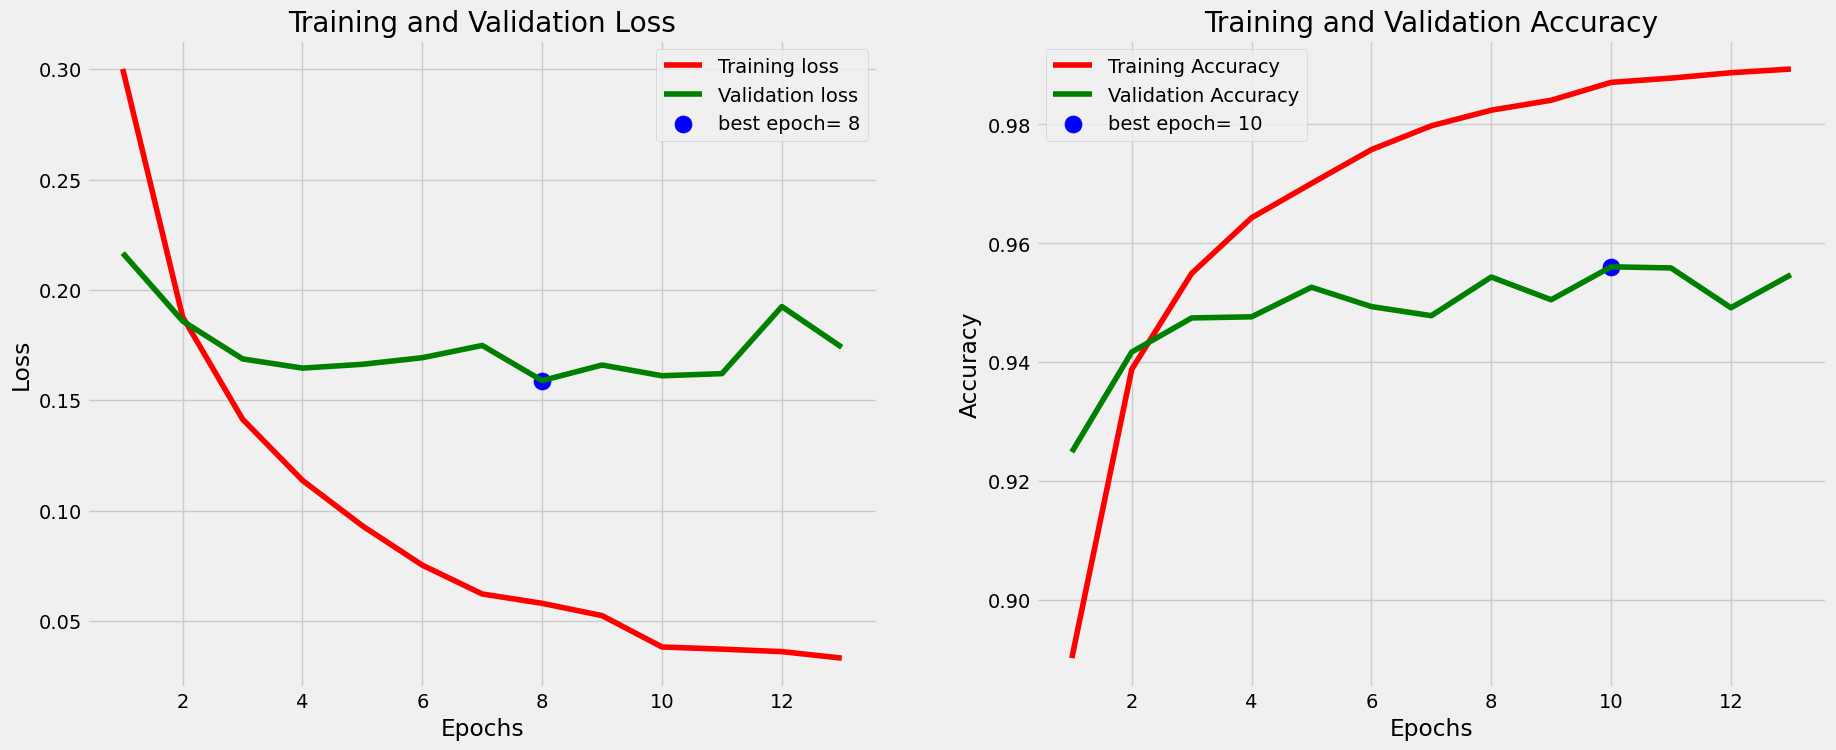

In [106]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [107]:
results = model.evaluate(val_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.16799
Test Accuracy: 95.09%


In [108]:
img_path = "/kaggle/input/animals10/raw-img/ragno/OIP--3TXG7fjM50XlBjTpcsfMgHaHa.jpeg"

test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (224 ,224))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

preds = model.predict(img_array)

print(class_names[np.argmax(preds[0])],'-',translate[class_names[np.argmax(preds[0])]])

(1, 224, 224, 3)
1/1 [==============================] - 0s 33ms/step
ragno - spider


In [109]:
model.save("vgg_ft_model.h5")

# Loading Saved Model <a class="anchor"  id="saved">

In [112]:
loaded_model = load_model("vgg_ft_model.h5")

In [114]:
img_path = "/kaggle/input/animals10/raw-img/gatto/1032.jpeg"

test_image = cv2.imread(img_path)
test_image = cv2.resize(test_image, (224 ,224))
im = tf.constant(test_image, dtype = tf.float32)
img_array = tf.expand_dims(im, axis = 0)
print(img_array.shape)

preds = loaded_model.predict(img_array)

print(class_names[np.argmax(preds[0])],'-',translate[class_names[np.argmax(preds[0])]])

(1, 224, 224, 3)
1/1 [==============================] - 0s 46ms/step
gatto - cat


**Model**:
    Test Loss: **0.16799**
Test Accuracy: **95.09%**